In [1]:
setwd("~/Upd-Germline-Genomics")

source("_targets.R")

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
library(GenomicRanges)

Loading required package: stats4

Loading required package: BiocGenerics




Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required pac

In [3]:
tar_load(
  c(
    matches("^chic.experiment.quantify_H3K(4|27|9)_(Germline|Somatic)_peakcalling.broad_chr"),
    chic.tile.diameter_1000_chr,
    chic.tile.diameter_500_score_chr,
    repli.timing_Germline_chr,
    repli.timing_Somatic_chr
  )
)

In [41]:
overlaps <- cross_join(
  tibble(celltype = c("Germline", "Somatic")),
  tibble(label = c("E", "EM", "ML", "L") %>% factor(., .))
) %>%
  group_by(celltype) %>%
  mutate(
    i = split(
      as.list(
        findOverlaps(chic.tile.diameter_1000_chr, chic.tile.diameter_500_score_chr)
      ),
      cut(
        get(str_glue("repli.timing_{celltype[1]}_chr"))$score,
        c(-Inf, -0.5, 0, 0.5, Inf)
      ) %>%
        factor(c("(0.5, Inf]", "(0,0.5]", "(-0.5,0]", "(-Inf,-0.5]"))
    ) %>%
      sapply(\(lst) unique(do.call(c, lst)))
  ) %>%
  print()

# A tibble: 8 × 3
# Groups:   celltype [2]
  celltype label i              
  <chr>    <fct> <named list>   
1 Germline E     <int [393,956]>
2 Germline EM    <int [385,440]>
3 Germline ML    <int [422,895]>
4 Germline L     <int [175,825]>
5 Somatic  E     <int [302,949]>
6 Somatic  EM    <int [449,353]>
7 Somatic  ML    <int [301,666]>
8 Somatic  L     <int [324,148]>


In [57]:
overlaps <- overlaps %>%
  mutate(i = i %>% sapply(\(v) subset(v, v %% 5 == 3))) %>%
  print()

# A tibble: 8 × 3
# Groups:   celltype [2]
  celltype label i             
  <chr>    <fct> <named list>  
1 Germline E     <int [78,792]>
2 Germline EM    <int [77,091]>
3 Germline ML    <int [84,580]>
4 Germline L     <int [35,160]>
5 Somatic  E     <int [60,590]>
6 Somatic  EM    <int [89,872]>
7 Somatic  ML    <int [60,332]>
8 Somatic  L     <int [64,829]>


In [58]:
chromatin <- overlaps %>%
  group_by(celltype, label) %>%
  reframe(
    tibble(
      H3K4 = get(str_glue("chic.experiment.quantify_H3K4_{celltype[1]}_peakcalling.broad_chr"))$L2FC[i[[1]]],
      H3K27 = get(str_glue("chic.experiment.quantify_H3K27_{celltype[1]}_peakcalling.broad_chr"))$L2FC[i[[1]]],
    )
  ) %>%
  subset(between(abs(H3K4), 1e-6, 9.9) & between(abs(H3K27), 1e-6, 9.9)) %>%
  print()

# A tibble: 501,951 × 4
   celltype label    H3K4   H3K27
   <chr>    <fct>   <dbl>   <dbl>
 1 Germline E     -0.0578 -0.196 
 2 Germline E     -0.286   0.339 
 3 Germline E     -0.869  -0.995 
 4 Germline E     -0.757  -0.220 
 5 Germline E     -1.56   -2.52  
 6 Germline E      0.826  -0.392 
 7 Germline E      0.427   0.0677
 8 Germline E      0.0333  0.316 
 9 Germline E     -0.218  -0.267 
10 Germline E     -1.18   -3.17  
# ℹ 501,941 more rows


In [97]:
args(facet_grid)

function (rows = NULL, cols = NULL, scales = "fixed", space = "fixed", 
    shrink = TRUE, labeller = "label_value", as.table = TRUE, 
    switch = NULL, drop = TRUE, margins = FALSE, facets = deprecated()) 
NULL

`geom_smooth()` using formula = 'y ~ x'


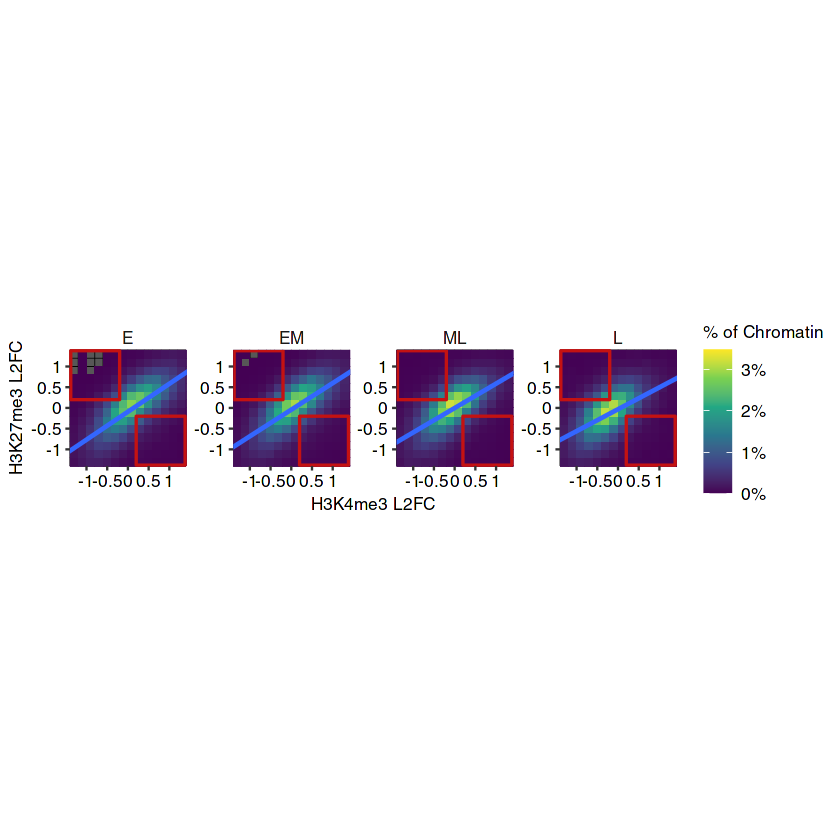

In [120]:
library(ggplot2)
library(scales)
plot_limits <- 7.4
annotate_polygon <- 1.38
p <- ggplot(chromatin, aes(H3K4, H3K27, fill = after_stat(density))) +
  facet_wrap(vars(label), scales = "free", nrow = 1) +
  geom_bin2d(binwidth = 0.2) +
  geom_smooth(aes(fill=NULL), method = "lm") +
  scale_fill_viridis_c(
    "% of Chromatin",
    limits = c(0, 0.035),
    labels = percent
  ) +
  annotate(
    "polygon",
    c(-annotate_polygon, -0.2, -0.2, -annotate_polygon),
    c(annotate_polygon, annotate_polygon, 0.2, 0.2),
    fill = "transparent",
    color = "#c41212",
    linewidth = 2 * 25.4 / 72,
  ) +
  annotate(
    "polygon",
    c(annotate_polygon, 0.2, 0.2, annotate_polygon),
    c(-annotate_polygon, -annotate_polygon, -0.2, -0.2),
    fill = "transparent",
    color = "#c41212",
    linewidth = 2 * 25.4 / 72,
  ) +
  scale_x_continuous(
    limits = c(-plot_limits, plot_limits), expand=c(0, 0),
    minor_breaks = seq(-1.4, 1.4, by=0.2),
    labels = as.numeric
  ) +
  scale_y_continuous(
    limits = c(-plot_limits, plot_limits), expand=c(0, 0),
    minor_breaks = seq(-1.4, 1.4, by=0.2),
    labels = as.numeric
  ) +
  coord_cartesian(c(-1.4,1.4), c(-1.4,1.4)) +
  labs(x = "H3K4me3 L2FC", y = "H3K27me3 L2FC") +
  theme(
    aspect.ratio = 1,
    axis.text = element_text(size = 10),
    axis.title = element_text(size = 10),
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 10),
    panel.background = element_rect(fill = "#575757"),
    panel.grid = element_line(color = "black", linewidth = 0.5 * 25.4 / 72),
    panel.grid.minor = element_line(color = "black", linewidth = 0.5 * 25.4 / 72),
    panel.border = element_blank(),
    plot.title = element_text(size = 10),
    strip.background = element_blank(),
    strip.text = element_text(size = 10, margin = margin(2, 2, 2, 2)),
  )
p

In [60]:
print(subset(chromatin, label == "E"))

# A tibble: 136,273 × 4
   celltype label    H3K4   H3K27
   <chr>    <fct>   <dbl>   <dbl>
 1 Germline E     -0.0578 -0.196 
 2 Germline E     -0.286   0.339 
 3 Germline E     -0.869  -0.995 
 4 Germline E     -0.757  -0.220 
 5 Germline E     -1.56   -2.52  
 6 Germline E      0.826  -0.392 
 7 Germline E      0.427   0.0677
 8 Germline E      0.0333  0.316 
 9 Germline E     -0.218  -0.267 
10 Germline E     -1.18   -3.17  
# ℹ 136,263 more rows


In [61]:
print(subset(chromatin, label == "EM"))

# A tibble: 159,140 × 4
   celltype label   H3K4   H3K27
   <chr>    <fct>  <dbl>   <dbl>
 1 Germline EM     0.573  0.255 
 2 Germline EM     0.434 -0.326 
 3 Germline EM     0.127 -0.198 
 4 Germline EM     0.158 -0.100 
 5 Germline EM    -0.560  0.200 
 6 Germline EM     0.964 -0.222 
 7 Germline EM     1.83   2.11  
 8 Germline EM    -1.39  -1.12  
 9 Germline EM    -0.139 -0.466 
10 Germline EM     0.275 -0.0369
# ℹ 159,130 more rows


In [89]:
correlations <- chromatin %>%
  group_by(celltype, label) %>%
  reframe(
    across(
      everything(),
      list(
        z = \(v) scale(v)[, 1],
        var = var
      )
    )
  ) %>%
  print() %>%
  group_by(label) %>%
  summarise(
    R_Germline = cor(H3K4_z[celltype == "Germline"], H3K27_z[celltype == "Germline"]),
    R_Somatic = cor(H3K4_z[celltype == "Somatic"], H3K27_z[celltype == "Somatic"]),
    Var_Germline_H3K4 = H3K4_var[match("Germline", celltype)],
    Var_Germline_H3K27 = H3K27_var[match("Germline", celltype)],
    Var_Somatic_H3K4 = H3K4_var[match("Somatic", celltype)],
    Var_Somatic_H3K27 = H3K27_var[match("Somatic", celltype)],
    model = lm(
        H3K27_z ~ H3K4_z * celltype
    ) %>%
      list()
  ) %>%
  print(width = 180)

# A tibble: 501,951 × 6
   celltype label  H3K4_z H3K4_var H3K27_z H3K27_var
   <chr>    <fct>   <dbl>    <dbl>   <dbl>     <dbl>
 1 Germline E     -0.180     0.440  -0.195     0.411
 2 Germline E     -0.524     0.440   0.640     0.411
 3 Germline E     -1.40      0.440  -1.44      0.411
 4 Germline E     -1.23      0.440  -0.232     0.411
 5 Germline E     -2.45      0.440  -3.82      0.411
 6 Germline E      1.15      0.440  -0.500     0.411
 7 Germline E      0.550     0.440   0.217     0.411
 8 Germline E     -0.0429    0.440   0.604     0.411
 9 Germline E     -0.421     0.440  -0.305     0.411
10 Germline E     -1.87      0.440  -4.84      0.411
# ℹ 501,941 more rows
# A tibble: 4 × 8
  label R_Germline R_Somatic Var_Germline_H3K4 Var_Germline_H3K27
  <fct>      <dbl>     <dbl>             <dbl>              <dbl>
1 E          0.673     0.654             0.440              0.411
2 EM         0.648     0.625             0.424              0.388
3 ML         0.632     0.518        

In [92]:
summary(correlations$model[[1]])


Call:
lm(formula = H3K27_z ~ H3K4_z * celltype)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.3940 -0.3801  0.0618  0.4663  5.8508 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -2.786e-16  2.699e-03   0.000        1    
H3K4_z                  6.726e-01  2.699e-03 249.183  < 2e-16 ***
celltypeSomatic         3.763e-16  4.081e-03   0.000        1    
H3K4_z:celltypeSomatic -1.903e-02  4.081e-03  -4.662 3.13e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7474 on 136269 degrees of freedom
Multiple R-squared:  0.4414,	Adjusted R-squared:  0.4414 
F-statistic: 3.589e+04 on 3 and 136269 DF,  p-value: < 2.2e-16


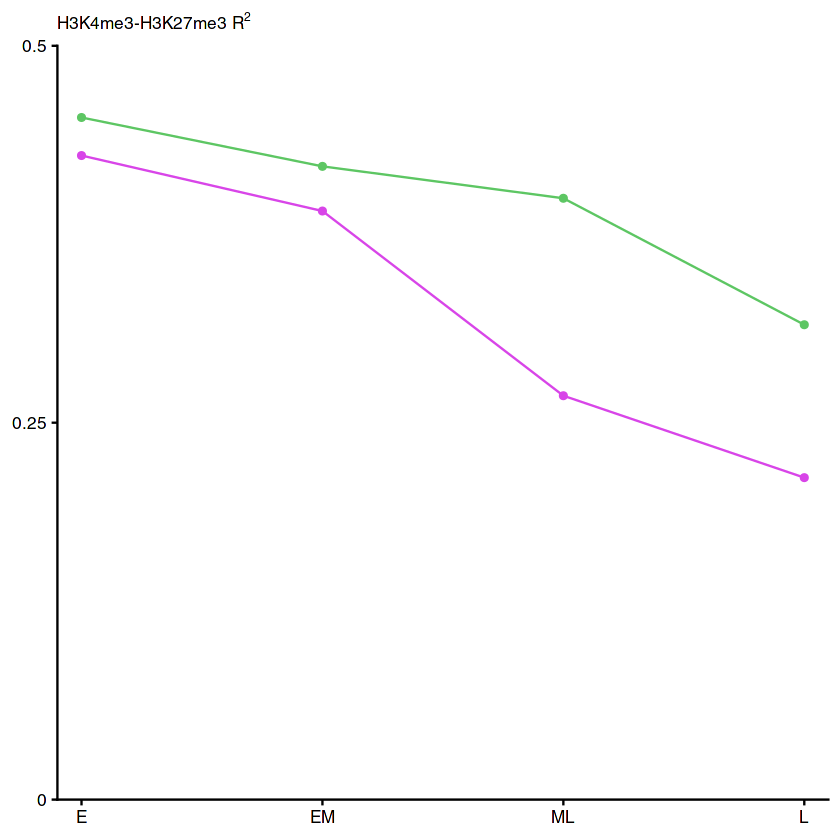

In [107]:
library(cowplot)
corrplot <- ggplot(correlations, aes(label)) +
  geom_line(aes(y = R_Germline^2, group = 1), color = chic_line_track_colors$germline) +
  geom_point(aes(y = R_Germline^2), color = chic_line_track_colors$germline) +
  geom_line(aes(y = R_Somatic^2, group = 1), color = chic_line_track_colors$somatic) +
  geom_point(aes(y = R_Somatic^2), color = chic_line_track_colors$somatic) +
  scale_y_continuous(breaks = c(0, 0.25, 0.5), labels = c("0", "0.25", "0.5")) +
  coord_cartesian(c(0.9, 4.1), c(0, 0.5), ex=F) +
  labs(title=bquote("H3K4me3-H3K27me3 R"^2), x = NULL, y = NULL) +
  theme_cowplot() +
  theme(
    axis.text = element_text(size = 10),
    plot.title = element_text(size = 10)
  )
corrplot

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


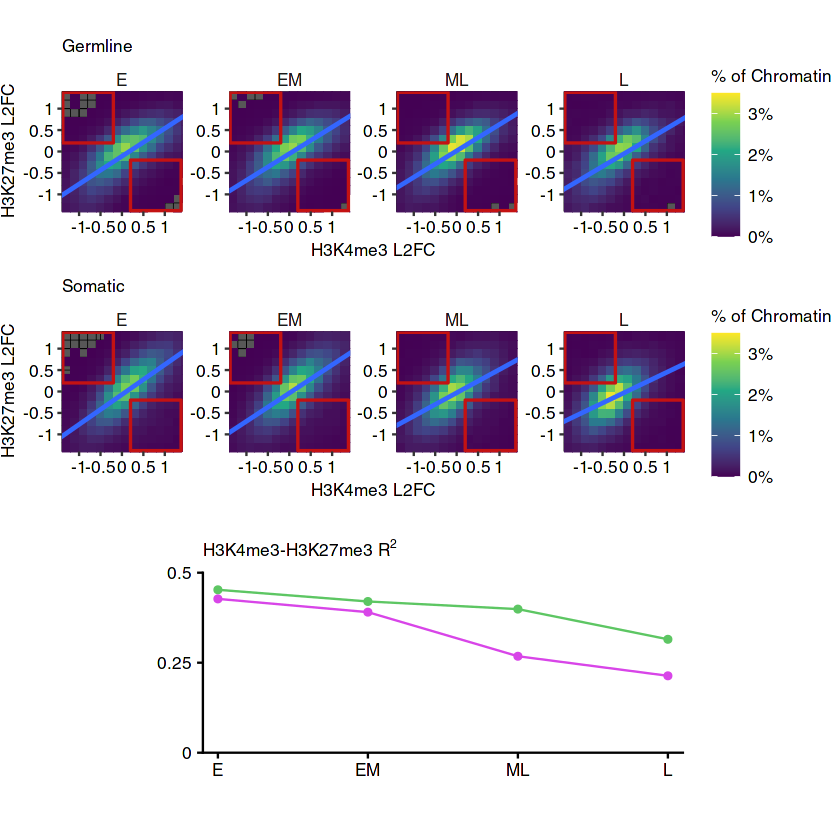

In [125]:
library(egg)
library(grid)
library(gtable)
report <- gtable(
  unit(1, "null"),
  unit(c(2, 2, 2.5), "in")
) %>%
  gtable_add_grob(
    list(
      set_panel_size(
        p %>%
          `$<-`("data", value = .$data %>% subset(celltype == "Germline")) %>%
          `+`(labs(title = "Germline")),
        w = unit(1, "in"),
        h = unit(1, "in")
      ),
      set_panel_size(
        p %>%
          `$<-`("data", value = .$data %>% subset(celltype == "Somatic")) %>%
          `+`(labs(title = "Somatic")),
        w = unit(1, "in"),
        h = unit(1, "in")
      ),
      set_panel_size(
        corrplot,
        w = unit(4, "in"),
        h = unit(1.5, "in")
      )
    ),
    t = 1:3,
    l = 1
  )
grid.draw(report)

In [126]:
library(Cairo)
CairoPDF("illustrations/Histone-Corr-Timing-Group.pdf", w = 11, h = 8.5)
grid.draw(report)
dev.off()

png 
  2